# Configuración

## Librerias

In [427]:
'''
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install opencv-python
'''

'\n!pip3 install numpy\n!pip3 install matplotlib\n!pip3 install tensorflow\n!pip3 install numpy\n'

In [428]:
import os
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf

## Constantes

In [429]:
BATCH_SIZE = 4
IMG_SIZE = (160, 160)

# Preprocesamiento

## Funciones

In [430]:
def preprocess_image(input_path, output_path, target_resolution=IMG_SIZE):

    try:
        # Load the image
        img = cv2.imread(input_path)

        try:
            img_corrected = np.power(img / 255.0, 1.5) * 255.0
        except Exception as e:
            print(f'Image {img} could not be gamma corrected due to    {e}' )

        try:
            img_contrast = cv2.convertScaleAbs(img_corrected, alpha=1.2, beta=0)
        except Exception as e:
            print(f'Image {img} could not be contrast corrected due to {e}' )

        try:
            img_resized = cv2.resize(img_contrast, target_resolution)
        except Exception as e:
            print(f'Image {img} could not be resized due to            {e}' )


        cv2.imwrite(output_path, img_resized)

    except:
        print(f'Image on {input_path} could not be loaded' )



def preprocess_images_in_directory(src_directory, dest_directory):
    # Iterate through train and validation directories
    for type in os.listdir(src_directory):
        dataset_path = os.path.join(src_directory, type)

        # Skip non-directory entries
        if not os.path.isdir(dataset_path):
            continue

        # Create corresponding directory in the destination
        dest_dataset_path = os.path.join(dest_directory, type)
        os.makedirs(dest_dataset_path, exist_ok=True)

        # Iterate through each season in the dataset
        for season in os.listdir(dataset_path):
            season_path = os.path.join(dataset_path, season)

            # Skip non-directory entries
            if not os.path.isdir(season_path):
                continue

            # Create a corresponding subdirectory in the destination directory
            dest_season_path = os.path.join(dest_dataset_path, season)
            os.makedirs(dest_season_path, exist_ok=True)

            # Iterate through each image in the season directory
            for filename in os.listdir(season_path):
                if filename.endswith(('.jpeg', '.jpg', '.png')):
                    input_path = os.path.join(season_path, filename)

                    # Generate the output path in the destination directory
                    output_path = os.path.join(dest_season_path, filename)

                    # Preprocess and save the image
                    print(f'Will now preprocess image on {type}/{season}/{filename}')
                    preprocess_image(input_path, output_path)

## Ejecucion

In [431]:
src_directory = "./static/images/estaciones_filtered"  # Adjust this to your input folder
dest_directory = "./static/images/estaciones_preprocessed"  # Adjust this to your output folder

In [432]:
#preprocess_images_in_directory(src_directory, dest_directory)

# Modelo

## Datasets desde folder

In [433]:
PATH ='./static/images/estaciones_corrected'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [434]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
                                                        train_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

Found 120 files belonging to 4 classes.


In [435]:
testing_dataset = tf.keras.utils.image_dataset_from_directory(
                                                        validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

Found 64 files belonging to 4 classes.


## Cardinalidad

In [436]:
val_batches_train = tf.data.experimental.cardinality(train_dataset)
print(f'Number of batches: {val_batches_train}')

Number of batches: 30


In [437]:
val_batches_test = tf.data.experimental.cardinality(testing_dataset)
print(f'Number of batches: {val_batches_test}')

Number of batches: 16


## División en validación y pruebas

In [438]:
test_dataset = testing_dataset.take(val_batches_test // 3)
validation_dataset = testing_dataset.skip(val_batches_test // 3)

In [439]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 5


# Modelo

## Datasets desde folder

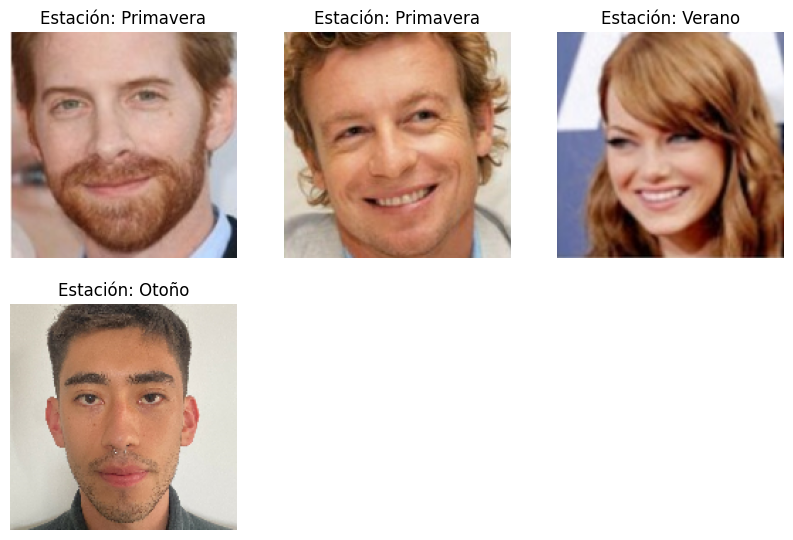

In [440]:
def estaciones(codigo):
    if (codigo == [0., 0., 1., 0.]).all():
        return 'Primavera'
    elif (codigo == [0., 1., 0., 0.]).all():
        return 'Verano'
    elif (codigo == [0., 0., 0., 1.]).all():
        return 'Otoño'
    elif (codigo == [1., 0., 0., 0.]).all():
        return 'Invierno'

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    estacion_codigo = estaciones(labels[i].numpy())
    plt.title(f'Estación: {estacion_codigo}')

In [441]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.RandomFlip('horizontal'),
  #tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness([-0.4,0.4]),
  tf.keras.layers.RandomZoom(height_factor=(-0.05, 0.2)),
])

(160, 160, 3)


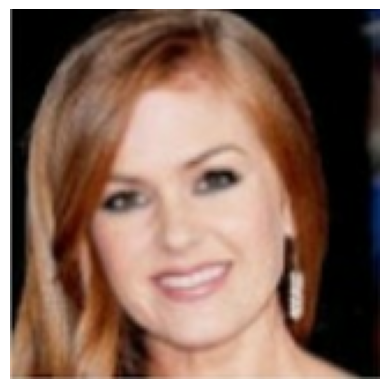

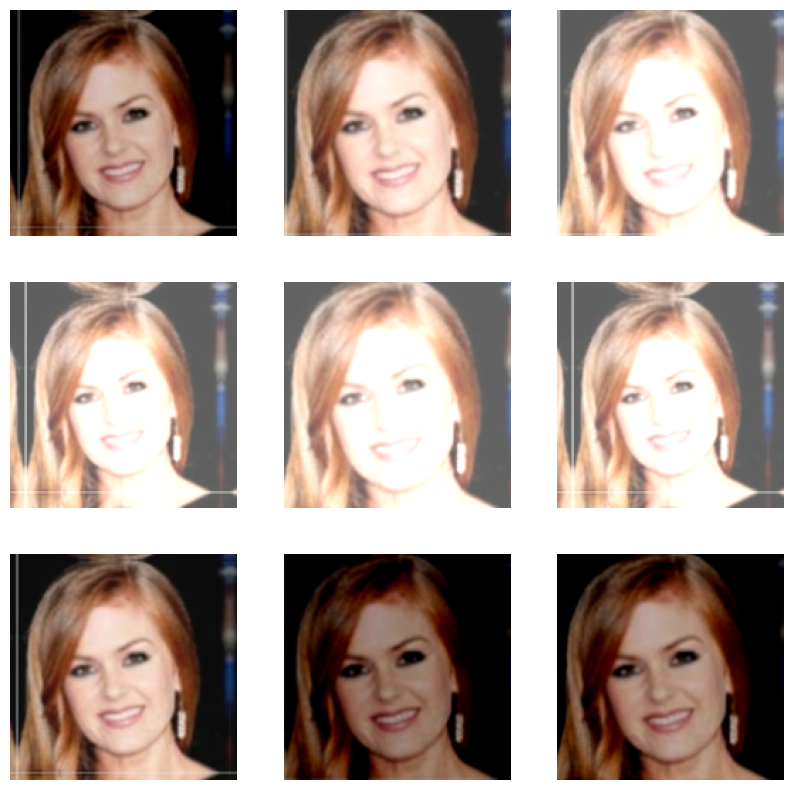

In [442]:
for image, _ in train_dataset.take(1):
  plt.figure()
  first_image = image[0]
  plt.imshow(first_image / 255)
  plt.axis('off')
  print(first_image.shape)
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [443]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [444]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [445]:
print(base_model.summary())
#tf.keras.utils.plot_model(base_model, to_file='model.png')

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_25[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [446]:
tf.keras.utils.plot_model(base_model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [447]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(4, 5, 5, 1280)


In [448]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 1280)


In [449]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 4)


In [450]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
outs = tf.keras.activations.softmax(outputs)
model = tf.keras.Model(inputs, outs)

In [451]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalHinge(),
              metrics=['accuracy'])

In [452]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 1s 14ms/step - loss: 1.2023 - accuracy: 0.2500
initial loss: 1.20
initial accuracy: 0.25


In [453]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50


30/30 [==============================] - 2s 21ms/step - loss: 1.1147 - accuracy: 0.3750 - val_loss: 1.0616 - val_accuracy: 0.3636
Epoch 2/50
30/30 [==============================] - 1s 21ms/step - loss: 1.0760 - accuracy: 0.4000 - val_loss: 1.0258 - val_accuracy: 0.4091
Epoch 3/50
30/30 [==============================] - 1s 20ms/step - loss: 1.0259 - accuracy: 0.4083 - val_loss: 1.0340 - val_accuracy: 0.4318
Epoch 4/50
30/30 [==============================] - 1s 20ms/step - loss: 1.0221 - accuracy: 0.4333 - val_loss: 1.0413 - val_accuracy: 0.4091
Epoch 5/50
30/30 [==============================] - 1s 20ms/step - loss: 1.0159 - accuracy: 0.4833 - val_loss: 1.0849 - val_accuracy: 0.3864
Epoch 6/50
30/30 [==============================] - 1s 20ms/step - loss: 1.0166 - accuracy: 0.4417 - val_loss: 1.0650 - val_accuracy: 0.4318
Epoch 7/50
30/30 [==============================] - 1s 20ms/step - loss: 0.9842 - accuracy: 0.5000 - val_loss: 1.0650 - val_accuracy: 0.4091
Epoch 8/50
30/30 [======

Text(0.5, 1.0, 'Training and Validation Accuracy')

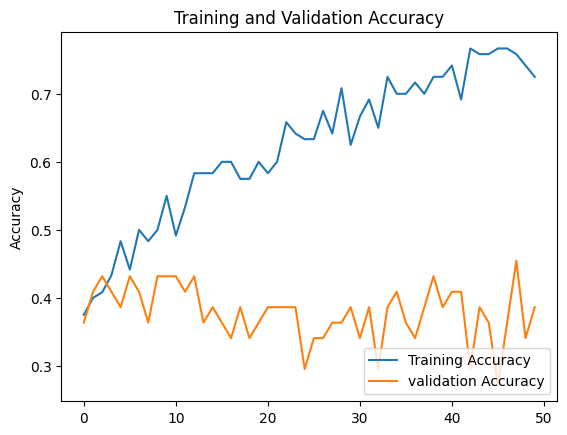

In [454]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')


In [455]:
model.save('./model/final_model.h5')

/home/vagabond/.pyenv/versions/3.11.3/envs/IA/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [456]:
base_model.trainable = True

capas_bloqueadas =len(base_model.layers)- 10

for layer in base_model.layers[:capas_bloqueadas]:
  layer.trainable = False

In [457]:
model.compile(loss=tf.keras.losses.CategoricalHinge(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [458]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0  

In [459]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 50/100
30/30 [==============================] - 3s 39ms/step - loss: 0.6081 - accuracy: 0.7333 - val_loss: 1.1512 - val_accuracy: 0.3636
Epoch 51/100
30/30 [==============================] - 1s 24ms/step - loss: 0.5888 - accuracy: 0.7417 - val_loss: 1.1334 - val_accuracy: 0.3409
Epoch 52/100
30/30 [==============================] - 1s 24ms/step - loss: 0.5692 - accuracy: 0.7750 - val_loss: 1.0732 - val_accuracy: 0.4318
Epoch 53/100
30/30 [==============================] - 1s 23ms/step - loss: 0.4865 - accuracy: 0.8083 - val_loss: 1.0646 - val_accuracy: 0.4318
Epoch 54/100
30/30 [==============================] - 1s 23ms/step - loss: 0.5211 - accuracy: 0.7667 - val_loss: 1.0201 - val_accuracy: 0.4545
Epoch 55/100
30/30 [==============================] - 1s 25ms/step - loss: 0.4417 - accuracy: 0.8500 - val_loss: 1.1441 - val_accuracy: 0.3864
Epoch 56/100
30/30 [==============================] - 1s 23ms/step - loss: 0.5196 - accuracy: 0.7750 - val_loss: 1.1172 - val_accuracy: 0.3864

Text(0.5, 1.0, 'Training and Validation Accuracy')

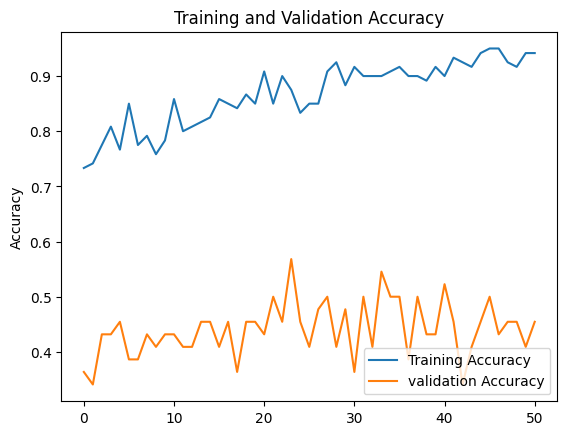

In [460]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

In [461]:
model.save('./model/final_model.h5')

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


TypeError: only integer scalar arrays can be converted to a scalar index

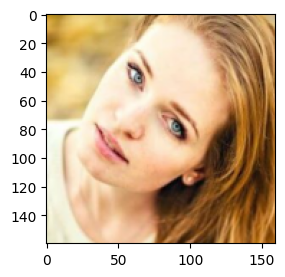

In [462]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(14, 28))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f' p:{class_names[predictions[i]]}, l:{class_names[label_batch[i]]}')
  plt.axis("off")

In [463]:
img_path = './static/images/t3.png'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)

class_labels = ['Invierno', 'Otoño', 'Primavera', 'Verano']

predicted_class_index = np.argmax(predictions[0])

predicted_class_label = class_labels[predicted_class_index]

print(f'Predicted class: {predicted_class_label}')
print(f'Predicted probabilities: {predictions[0]}')

1/1 [==============================] - 0s 481ms/step
Predicted class: Invierno
Predicted probabilities: [0.4797749  0.16639397 0.33888954 0.01494164]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99412c2e-f061-48b1-b330-0dfd48ccdcce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>